In [1]:
# Playing with rotation matricies

import numpy as np
import math

def RotationMatrix(x,y,z):
    lat = x
    long = y
    twist = z
    lat = math.radians(lat)
    long = math.radians(long)
    twist = math.radians(twist)


    Rx = np.array([[1,0,0],
                   [0,np.cos(twist),-np.sin(twist)],
                   [0,np.sin(twist),np.cos(twist)]])
    Ry = np.array([[np.cos(lat),0,np.sin(lat)],
                   [0,1,0],
                   [-np.sin(lat),0,np.cos(lat)]])
    Rz = np.array([[np.cos(twist),-np.sin(twist),0],
                   [np.sin(twist),np.cos(twist),0],
                   [0,0,1]])
    Rz2 = np.array([[np.cos(long),-np.sin(long),0],
                   [np.sin(long),np.cos(long),0],
                   [0,0,1]])

    #R = np.matmul(Rz2,Ry,Rx)
    R = np.matmul(Rz2,Ry,Rz)
    R[np.abs(R) < 0.0001] = 0
    return R


In [ ]:
# Patrick script

# Input: Takes in the GML file 
# Output: A Dictionary indexed by Building Identification with attributes
#         X (min, max), Y (min, max), Z (min, max), BIN, DOITT_ID, SOURCE_ID
def parse(GML_file):
    fp = open(GML_file)
    buildings = dict()
    current = None
    for line in fp:
        if "bldg:Building" in line:
            raw_name = fp.readline()
            bldg_id = raw_name.split('>')[1].split('<')[0]
            buildings[bldg_id] = dict()
            buildings[bldg_id]["X"] = [float("inf"),-float("inf")]
            buildings[bldg_id]["Y"] = [float("inf"),-float("inf")]
            buildings[bldg_id]["Z"] = [float("inf"),-float("inf")]
            current = bldg_id
        if "/bldg:Building" in line:
            current = None
        if "BIN" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['BIN'] = bld_id
        if "DOITT_ID" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['DOITT_ID'] = bld_id
        if "SOURCE_ID" in line:
            raw_value = fp.readline()
            bld_id = raw_value.split('>')[1].split('<')[0]
            buildings[current]['SOURCE_ID'] = bld_id
        if "<gml:posList>" in line and "</gml:posList>" in line:
            points = line.split('>')[1].split('<')[0]
            points = points.split(' ')
            for p in range(len(points)//3):
                x = float(points[3*p])
                y = float(points[3*p+1])
                z = float(points[3*p+2])
                if x > buildings[bldg_id]["X"][1]:
                    buildings[bldg_id]["X"][1] = x
                if x < buildings[bldg_id]["X"][0]:
                    buildings[bldg_id]["X"][0] = x
                if y > buildings[bldg_id]["Y"][1]:
                    buildings[bldg_id]["Y"][1] = y
                if y < buildings[bldg_id]["Y"][0]:
                    buildings[bldg_id]["Y"][0] = y
                if z > buildings[bldg_id]["Z"][1]:
                    buildings[bldg_id]["Z"][1] = z
                if z < buildings[bldg_id]["Z"][0]:
                    buildings[bldg_id]["Z"][0] = z
    return buildings

In [2]:
# Adjusted Patrick script

# Input: Takes in the GML file 
# Output: A dictionary with key = Building Identification (e.g. Bldg_12210009096) 
#         and value = [(X1, Y1, Z1), (X2, Y2, Z2), etc.] for each polygon that makes up the building
def parseAllCoordinates(GML_file):
    fp = open(GML_file)
    buildings = dict()
    current = None
    for line in fp:
        if "bldg:Building" in line:
            raw_name = fp.readline()
            bldg_id = raw_name.split('>')[1].split('<')[0]
            buildings[bldg_id] = dict()
            buildings[bldg_id] = []
            current = bldg_id
        if "<gml:posList>" in line and "</gml:posList>" in line:
            points = line.split('>')[1].split('<')[0]
            points = points.split(' ')
            polygon = []
            for p in range(len(points)//3):
                x = float(points[3*p])
                y = float(points[3*p+1])
                z = float(points[3*p+2])
                polygon.append((x,y,z))
            buildings[current].append(polygon)
        if "/bldg:Building" in line:
            current = None
                
    return buildings

In [81]:
# original changed patrick script
def parseAllCoordinates2(GML_file):
    fp = open(GML_file)
    buildings = dict()
    current = None
    for line in fp:
        if "bldg:Building" in line:
            raw_name = fp.readline()
            bldg_id = raw_name.split('>')[1].split('<')[0]
            buildings[bldg_id] = []
            current = bldg_id
        if "<gml:posList>" in line and "</gml:posList>" in line:
            points = line.split('>')[1].split('<')[0]
            points = points.split(' ')
            for p in range(len(points)//3):
                x = float(points[3*p])
                y = float(points[3*p+1])
                z = float(points[3*p+2])
                buildings[current].append((x,y,z))
        if "/bldg:Building" in line:
            current = None
                
    return buildings

In [5]:
GML_file = '/Users/mogryzko/Desktop/NYC buildings 3D/DA_WISE_GMLs/test/DA12_3D_Buildings_Merged.gml'

building_pts = parseAllCoordinates(GML_file)
print(len(building_pts))


24039


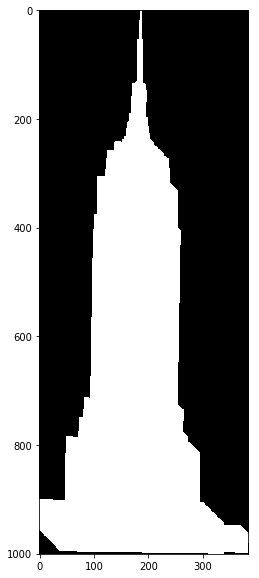

In [12]:
# Testing polygons

import numpy as np
import matplotlib.pyplot as plt
import cv2

pixel_size = 0.00122 # in mm
focal_length = 25 # in mm
fx = focal_length/pixel_size
fy = focal_length/pixel_size

intrinsic_matrix = np.array([[fx,0,0],
                            [0,fy,0],
                            [0,0,1]])

R = np.array([[0.822486, -0.568586, 0.0150485],
              [0.0330608, 0.0742028, 0.996695],
              [-0.567824, -0.81927, 0.0798287]])
T = np.array([[-986570],[-209681],[-311.523]])


extrinsic_matrix = np.append(R,T,axis=1)

camera_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix) 

total_num_pts = 0
for polygon in building_pts['Bldg_12210009096']:
    total_num_pts += len(polygon)

all_2D_pts = np.zeros((total_num_pts,2)) # for np.max and np.min

twoD_pts = []
all_idx = 0
for polygon in building_pts['Bldg_12210009096']:
    poly_pts = np.zeros((len(polygon),2))
    for idx, pt in enumerate(polygon):
        new_pt = np.append(np.array(pt),np.array([1]), axis=0)
        new_pt = np.matmul(camera_matrix,new_pt)
        new_pt = new_pt[:2]/new_pt[2]
        poly_pts[idx] = new_pt
        all_2D_pts[all_idx] = new_pt #for np.max and np.min
        all_idx += 1
    twoD_pts.append(poly_pts)
    
max_x = np.max(all_2D_pts[:,0])
min_x = np.min(all_2D_pts[:,0])
max_y = np.max(all_2D_pts[:,1])
min_y = np.min(all_2D_pts[:,1])

# adjust pts to fit within window
if min_x < 0:
    for poly in twoD_pts:
        poly[:,0] -= min_x
    all_2D_pts[:,0] -= min_x
if min_y < 0:
    for poly in twoD_pts:
        poly[:,1] -= min_y
    all_2D_pts[:,1] -= min_y
    
max_x = np.max(all_2D_pts[:,0])
min_x = np.min(all_2D_pts[:,0])
max_y = np.max(all_2D_pts[:,1])
min_y = np.min(all_2D_pts[:,1])


scale = (max_y-min_y) / 1000

new_img = np.zeros((1001, int((max_x-min_x)/scale)+1))

for idx,poly in enumerate(twoD_pts):
    poly[:,0] -= min_x
    poly[:,0] /= scale
    poly[:,1] -= min_y
    poly[:,1] /= scale
    twoD_pts[idx] = poly.astype(int)


for poly in twoD_pts:
    #cv2.polylines(new_img,[poly],False,(255,255,255))
    cv2.fillPoly(new_img, pts=[poly], color=(255,255,255))

      
plt.figure(figsize=(20,10))

plt.imshow(new_img,cmap='gray')
plt.show()
plt.imsave('filled_empire.png', new_img, cmap='gray')


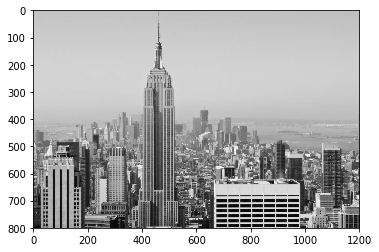

(800, 1200) (400, 600)


TypeError: only size-1 arrays can be converted to Python scalars

In [35]:
empire_real = cv2.imread('empire.png')
empire_real = cv2.cvtColor(empire_real, cv2.COLOR_BGR2GRAY)
plt.imshow(empire_real,cmap='gray')
plt.show()

w,h = empire_real.shape

new_img = cv2.resize(new_img, (h//2,w//2))

W,H = new_img.shape

width = w-W+1
height = h-H+1
result = np.zeros((width,height))
#result = cv2.CreateImage((width, height), 32, 1)
print(empire_real.shape,new_img.shape)
cv2.matchTemplate(empire_real, new_img, result, cv2.TM_SQDIFF)
print(result)

In [48]:
def extract(s):
    pixel_size = s[s.find('PixelSizeMm') + 13:]
    pixel_size = float(pixel_size[:pixel_size.find(' ')])
    #edit
    pixel_size = 0.00122
    focal_length = s[s.find('FocalMm') + 9:]
    focal_length = float(focal_length[:focal_length.find('"')])
    #edit
    focal_length = 25
    fx = focal_length/pixel_size
    fy = focal_length/pixel_size
    intrinsic_matrix = np.array([[fx,0,0],
                            [0,fy,0],
                            [0,0,1]])
    rotation_matrix = s[s.find('RotationMatrix') + 16:]
    rm = [float(i) for i in rotation_matrix[:rotation_matrix.find('"')].split(' ')[:-1]]
    R = np.array([rm[:3],rm[4:7],rm[8:11]])
    #edit
    #R = np.linalg.inv(R)
    print(R)
    translation_vector = s[s.find('TranslationVector') + 19:]
    T = np.array([[float(i)] for i in translation_vector[:translation_vector.find('"')].split(' ')[:-1]])
    print(T)
    extrinsic_matrix = np.append(R,T,axis=1)

    camera_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)
    return camera_matrix

In [49]:
def CameraMatrix(R,T):
    focal_length = 25
    pixel_size = 0.00122
    fx = focal_length/pixel_size
    fy = focal_length/pixel_size
    intrinsic_matrix = np.array([[fx,0,0],
                            [0,fy,0],
                            [0,0,1]])
    extrinsic_matrix = np.append(R,T,axis=1)
    camera_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)
    return camera_matrix

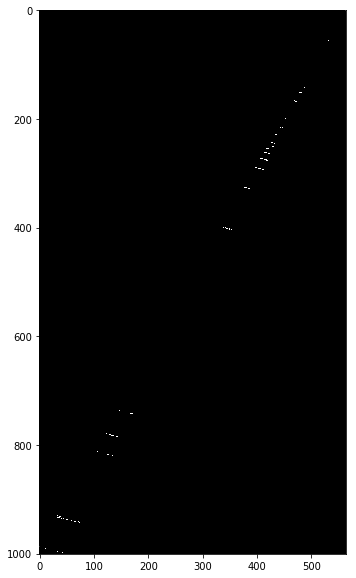

In [85]:
# TESTING 

import numpy as np
import matplotlib.pyplot as plt

# examples that work and dont work


pixel_size = 0.00122 # in mm
focal_length = 25 # in mm
#pixel_size = 0.0369161 # in mm
#focal_length = 19.8855 # in mm
fx = focal_length/pixel_size
fy = focal_length/pixel_size

intrinsic_matrix = np.array([[fx,0,0],
                            [0,fy,0],
                            [0,0,1]])

#R = np.array([[0.822486, -0.568586, 0.0150485],
#              [0.0330608, 0.0742028, 0.996695],
#              [-0.567824, -0.81927, 0.0798287]])
#T = np.array([[-986570],[-209681],[-311.523]])

R = np.array([[0.835509, -0.548552, -0.0318717],
              [0.547759, 0.826911, 0.12719],
              [-0.0434153, -0.123726, 0.991366]])
#R = np.linalg.inv(R)

T = np.array([[-988082],[-210924],[-2937.02]])

extrinsic_matrix = np.append(R,T,axis=1)

camera_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)

new_pts = np.zeros((len(building_pts['Bldg_12210009096']),2))

idx = 0
for pt in building_pts['Bldg_12210009096']:
    new_pt = np.append(np.array(pt),np.array([1]), axis=0)
    new_pt = np.matmul(camera_matrix,new_pt)
    new_pt = new_pt[:2]/new_pt[2]
    new_pts[idx] = new_pt
    idx += 1
    
max_x = np.max(new_pts[:,0])
min_x = np.min(new_pts[:,0])
max_y = np.max(new_pts[:,1])
min_y = np.min(new_pts[:,1])


# adjust pts to fit within window
if min_x < 0:
    new_pts[:,0] -= min_x
if min_y < 0:
    new_pts[:,1] -= min_y
    
max_x = np.max(new_pts[:,0])
min_x = np.min(new_pts[:,0])
max_y = np.max(new_pts[:,1])
min_y = np.min(new_pts[:,1])

scale = (max_y-min_y) / 1000

new_img = np.zeros((1001, int((max_x-min_x)/scale)+1))
# pixels_y, pixels_x = int((max_y-min_y)*scale), int((max_x-min_x)*scale)
# new_img = np.zeros((pixels_y, pixels_x))


for pt in new_pts:
    new_img[int((pt[1]-min_y)/scale),int((pt[0]-min_x)/scale)] = 1


        
plt.figure(figsize=(20,10))

plt.imshow(new_img,cmap='gray')
plt.show()

#plt.imsave('new_img.png', new_img, cmap='gray')


In [50]:
import numpy as np
import random

def RANSAC(Xs, Xd, max_iter, eps):
    # Input:
    #     pts1: the first set of points, shape [n, 2]
    #     pts2: the second set of points matched to the first set, shape [n, 2]
    #     max_iter: max iteration number of RANSAC
    #     eps: tolerance of RANSAC
    # Output:
    #     inliers_id: the indices of matched pairs when using the homography given by RANSAC
    #     H: the homography, shape [3, 3]
    n,_ = Xs.shape
    inliers_id = []
    max_inliers = 0
    H = np.array([])
    
    for i in range(max_iter):
        idxs = np.random.randint(n, size=4)
        src_pts = np.array([Xs[idxs[0]],Xs[idxs[1]],Xs[idxs[2]],Xs[idxs[3]]])
        dst_pts = np.array([Xd[idxs[0]],Xd[idxs[1]],Xd[idxs[2]],Xd[idxs[3]]])
        temp_H = compute_homography(src_pts,dst_pts)
        temp_inliers = []
        temp_max = 0
        proj_pts = apply_homography(Xs,temp_H)
        for j in range(n):
            src_pt = np.append(Xs[j],1)
            proj_pt = proj_pts[j]
            real_pt = Xd[j]
            dist = np.linalg.norm(proj_pt-real_pt)
            if dist <= eps:
                temp_inliers.append(j)
                temp_max += 1
        
        if temp_max > max_inliers:
            inliers_id = temp_inliers
            max_inliers = temp_max
            H = temp_H
                
    return inliers_id, H

import cv2
import numpy as np

def genSIFTMatchPairs(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    pts1 = np.zeros((250,2))
    pts2 = np.zeros((250,2))
    for i in range(250):
        pts1[i,:] = kp1[matches[i].queryIdx].pt
        pts2[i,:] = kp2[matches[i].trainIdx].pt
    
    return pts1, pts2, matches[:250], kp1, kp2

In [ ]:
# red lines sift pairs

import numpy as np
import matplotlib.pyplot as plt
import cv2

inliers_idx, H = RANSAC(pts1, pts2, 500, 20)

new_matches = []
for i in range(len(inliers_idx)):
    new_matches.append(matches[inliers_idx[i]])

matching_result = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

write_output_img("test3.png", matching_result)
plt.show()

In [63]:
import math
points = '987983.830447003 219279.540165231 150.173699999999 987987.853732914 219277.301324561 150.173699999999 987980.097186744 219263.361719891 150.173699999999 987985.406231239 219260.407329485 150.173699999999 987993.302212834 219274.597261727 150.173699999999 987994.384231657 219273.995228812 150.173699999999 987997.388490751 219279.394168153 150.173699999999 987986.973813415 219285.189432144 150.173699999999 987983.830447003 219279.540165231 150.173699999999'

points = points.split()
points = [math.floor(float(pt)) for pt in points]
points2 = []
for idx, pt in enumerate(points, 1):
    if idx % 3 == 0:
        points2.append((points[idx-3],points[idx-2], points[idx-1]))
points = points2



[(987983, 219279, 150), (987987, 219277, 150), (987980, 219263, 150), (987985, 219260, 150), (987993, 219274, 150), (987994, 219273, 150), (987997, 219279, 150), (987986, 219285, 150), (987983, 219279, 150)] [987983, 219279, 150, 987987, 219277, 150, 987980, 219263, 150, 987985, 219260, 150, 987993, 219274, 150, 987994, 219273, 150, 987997, 219279, 150, 987986, 219285, 150, 987983, 219279, 150]


In [118]:
def rotation_matrix(x,y,z):
    # x,y,z = 0 when phone is flat on table with top facing east 
    # normalize from -1 to 1 to 0 to 2pi
    
    theta = y,x,z
    
    theta = [axis % 2 * np.pi for axis in theta]
    
    
    R_x = np.array([[1,               0,                0],
                    [0,np.cos(theta[0]),-np.sin(theta[0])],
                    [0,np.sin(theta[0]), np.cos(theta[0])]
                    ])
                     
    R_y = np.array([[np.cos(theta[1]),    0,      np.sin(theta[1])  ],
                    [0,                   1,          0             ],
                    [-np.sin(theta[1]),   0,      np.cos(theta[1])  ]
                    ])
                 
    R_z = np.array([[np.cos(theta[2]),  -np.sin(theta[2]),    0],
                    [np.sin(theta[2]),   np.cos(theta[2]),    0],
                    [0,                     0,                1]
                    ])
                     
                     
    R = np.dot(R_z, np.dot( R_y, R_x ))
 
    return R

def rot2mesh(rot):
    return '''<!DOCTYPE ViewState>
<project>
 <VCGCamera  RotationMatrix="{0} {1} {2} 0 {3} {4} {5} 0 {6} {7} {8} 0 0 0 0 1 " LensDistortion="0 0" TranslationVector="-986928 -207324 -762.533 1" FocalMm="55.1807" CameraType="0" PixelSizeMm="0.0369161 0.0369161" ViewportPx="2397 1726" CenterPx="1198 863"/>
 <ViewSettings NearPlane="0.909327" TrackScale="0.018121" FarPlane="116.735"/>
</project>'''.format(*[round(i,7) for i in rot.flatten()])

In [119]:
print(rot2mesh(rotation_matrix(0.2,-.5,0)))

<!DOCTYPE ViewState>
<project>
 <VCGCamera  RotationMatrix="0.809017 -0.5877853 -0.0 0 0.0 -0.0 1.0 0 -0.5877853 -0.809017 -0.0 0 0 0 0 1 " LensDistortion="0 0" TranslationVector="-986928 -207324 -762.533 1" FocalMm="55.1807" CameraType="0" PixelSizeMm="0.0369161 0.0369161" ViewportPx="2397 1726" CenterPx="1198 863"/>
 <ViewSettings NearPlane="0.909327" TrackScale="0.018121" FarPlane="116.735"/>
</project>


In [ ]:
# examples that work and dont work


#pixel_size = 0.00122 # in mm
#focal_length = 25 # in mm
pixel_size = 0.0369161 # in mm
focal_length = 19.8855 # in mm
fx = focal_length/pixel_size
fy = focal_length/pixel_size

intrinsic_matrix = np.array([[fx,0,0],
                            [0,fy,0],
                            [0,0,1]])

#R = np.array([[0.822486, -0.568586, 0.0150485],
#              [0.0330608, 0.0742028, 0.996695],
#              [-0.567824, -0.81927, 0.0798287]])
#T = np.array([[-986570],[-209681],[-311.523]])

R = np.array([[0.835509, -0.548552, -0.0318717],
              [0.547759, 0.826911, 0.12719],
              [-0.0434153, -0.123726, 0.991366]])
R = np.linalg.inv(R)

T = np.array([[-988082],[-210924],[-2937.02]])

extrinsic_matrix = np.append(R,T,axis=1)

camera_matrix = np.matmul(intrinsic_matrix, extrinsic_matrix)